In [1]:
import sys 
sys.path.append("..")

In [28]:
import umap
import operator
import shap
from xgboost import XGBClassifier
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from ksvd import ApproximateKSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from comon import creatMas, plot_ssp, creat_data_month
from plots_report import plot_metrics

In [3]:
ocean = 'BarentsSea'

In [4]:
files = ['CZ1.txt', 'CZ2.txt', 'CZ3.txt', 'CZ4.txt','CZ5.txt', 'CZ6.txt',
         'CZ7.txt','CZ8.txt','CZ9.txt','CZ10.txt', 'CZ11.txt','CZ12.txt']

CZ = []
for file in files:
    with open('{0}/{1}'.format(ocean, file), 'r') as f:
        line = f.readlines()
        cz=creatMas(line)
    CZ.append(cz)
    
_, N_cord = cz.shape

with open('{}/zs.txt'.format(ocean), 'r') as f:
    line = f.readlines()
    line.remove(line[N_cord])
zs = [-int(a) for a in line]

In [5]:
def AEncoder(input_dim, latent_dim):
    hidden_layer = int(input_dim * 0.8)
    
    inputs = Input(shape=(input_dim,))
    inp_layar1 = Dense(hidden_layer, activation='softplus',kernel_initializer='he_normal')(inputs)
    #np_layar1 = Dropout(0.1)(inp_layar1)
    
    encoded = Dense(latent_dim, activation='softplus', kernel_initializer='he_normal')(inp_layar1)
    
    dec_lay = Dense(hidden_layer,activation='linear', kernel_initializer='he_normal')(encoded)
    #dec_lay = Dropout(0.1)(dec_lay)
    decoded = Dense(input_dim,activation='linear', kernel_initializer='he_normal')(dec_lay)
    
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

In [6]:
def researcher_pca(CLF,X_train, Y_train, X_test, Y_test, n_comp=[3,5,7,10]):
    scores = []
    for n in n_comp:
        dec = PCA(n_components=n)
        clf = CLF()
        pipe = Pipeline([('dec', dec), ('clf', clf)])
        pipe.fit(X_train, Y_train)
        predict = pipe.predict(X_test)
        score = accuracy_score(Y_test, predict)
        scores.append(score)
    return scores



def researcher_ksvd(CLF, X_train, Y_train, X_test, Y_test, n_comp=[3,5,7,10]):
    scores = []
    for n in n_comp:
        ksvd = ApproximateKSVD(n_components=n, transform_n_nonzero_coefs=n//2)
        meantr = np.mean(X_train,axis=0)
        dictionary = ksvd.fit(X_train - meantr).components_
        gamma_train = ksvd.transform(X_train - meantr)
        gamma_test = ksvd.transform(X_test - meantr)
        
        clf = CLF()
        clf.fit(gamma_train, Y_train)
        predict = clf.predict(gamma_test)
        score = accuracy_score(Y_test, predict)
        scores.append(score)
    return scores


def researcher_ae(CLF, X_train, Y_train, X_test, Y_test, n_comp=[3,5,7,10]):
    scores = []
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    for n in n_comp:
        autoencoder_std, encoder_std = AEncoder(N_cord, n)
        autoencoder_std.fit(X_train_std, X_train_std,
                epochs=750,
                batch_size=64,
                shuffle=True, verbose=0)
          
        test_embedding = encoder_std.predict(X_test_std)
        train_embedding = encoder_std.predict(X_train_std)
        
        clf = CLF()
        clf.fit(train_embedding, Y_train)
        predict = clf.predict(test_embedding)
        score = accuracy_score(Y_test, predict)
        scores.append(score)
    return scores

In [7]:
def plot_confusion_matrix(cm, classes=['winter', 'summer'],
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def print_metrics(clf, X_train, X_test, y_train, y_test):
    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)
    print('Accuracy на тренировочных данных: {}'.format(accuracy_score(y_train, predict_train)))
    print('Accuracy на тестовых данных: {}'.format(accuracy_score(y_test, predict_test)))
    
    plot_confusion_matrix(confusion_matrix(y_train, predict_train), title='Confusion matrix для обучающих данных')
    plot_confusion_matrix(confusion_matrix(y_test, predict_test), title='Confusion matrix для тестовых данных')
    
def feature_importances(clf, size = (10,12), title_x = 'Важность координаты', title_y = 'Глубина', zs = zs):
    fi = clf.feature_importances_
    x = range(1,len(fi)+1)
    plt.figure(figsize=size)
    plt.barh(x, fi)
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.yticks(x,list(map(str,zs)))
    plt.show()

In [44]:
X, Y = creat_data_month(CZ)
X = pd.DataFrame(X, columns=zs)
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.2, stratify=Y, random_state=0)

In [45]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
predict = clf.predict(X_test)
print('accuracy_score: ', accuracy_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

accuracy_score:  0.8660714285714286
[[121   8   0   8   3   0   0   0   0   0   0   0]
 [  2 110   5   0  23   0   0   0   0   0   0   0]
 [ 16   2 107  15   0   0   0   0   0   0   0   0]
 [ 39   0  23  55  15   1   0   0   0   0   0   7]
 [  3   9   0   3 117   5   0   0   0   0   3   0]
 [  0   0   3   0   0 136   0   0   0   0   0   1]
 [  0   0   0   0   0   1 139   0   0   0   0   0]
 [  0   0   0   0   0   0  16 119   5   0   0   0]
 [  1   0   0   0   0   0   0   0 139   0   0   0]
 [  0   0   0   0   0   0   0   0   1 139   0   0]
 [  1   0   0   0   0   0   0   0   0   0 139   0]
 [  3   0   2   0   0   0   0   0   0   0   1 134]]
              precision    recall  f1-score   support

           1       0.65      0.86      0.74       140
           2       0.85      0.79      0.82       140
           3       0.76      0.76      0.76       140
           4       0.68      0.39      0.50       140
           5       0.74      0.84      0.79       140
           6       0.95   

In [47]:
clf = XGBClassifier(n_estimators=1000)
clf.fit(X_train,y_train)
predict = clf.predict(X_test)
print('accuracy_score: ', accuracy_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

accuracy_score:  0.975
[[136   1   2   0   0   0   0   0   0   0   0   1]
 [  3 137   0   0   0   0   0   0   0   0   0   0]
 [  1   3 131   5   0   0   0   0   0   0   0   0]
 [  0   1   4 132   2   1   0   0   0   0   0   0]
 [  0   0   1   6 133   0   0   0   0   0   0   0]
 [  0   0   0   0   0 140   0   0   0   0   0   0]
 [  0   0   0   0   0   0 140   0   0   0   0   0]
 [  0   0   0   0   0   0   0 140   0   0   0   0]
 [  0   0   0   0   0   0   0   0 140   0   0   0]
 [  1   0   0   2   2   0   0   0   0 135   0   0]
 [  0   1   0   0   1   0   0   0   0   0 138   0]
 [  2   0   0   0   0   0   0   0   0   0   2 136]]
              precision    recall  f1-score   support

           1       0.95      0.97      0.96       140
           2       0.96      0.98      0.97       140
           3       0.95      0.94      0.94       140
           4       0.91      0.94      0.93       140
           5       0.96      0.95      0.96       140
           6       0.99      1.00      

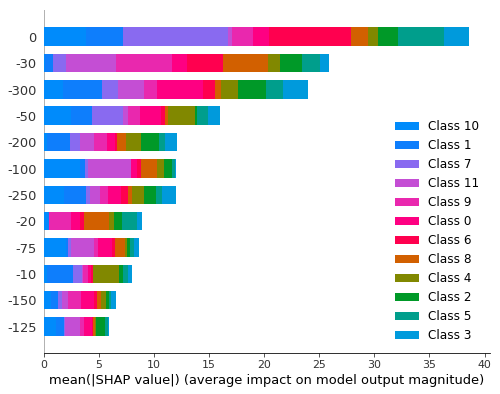

In [49]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type = "bar")